#### Testing different solvers (Pardiso, SimPEG/SciPy, CuPY, and PyTorch) using 3D DC Resistivity problem.


This notebook uses the example simulation for 3D DC Resistivity from SimPEG tutorials: https://simpeg.xyz/user-tutorials/fwd-dcr-3d

Examples run on a cluster node with following specs:
#### GPU specs:
| GPU Name | Memory-Usage |
| --- | --- |
| NVIDIA RTX A6000 | 49140MiB |
| NVIDIA RTX A6000 | 49140MiB |
| NVIDIA RTX A6000 | 49140MiB |

#### CPU specs:
| |  |
| --- | --- |
| Model name | Intel(R) Xeon(R) Gold 5317 CPU @ 3.00GHz |
| CPU family | 6 |
| Model | 106 |
| Thread(s) per core | 2 |
| Core(s) per socket | 12 |
| Socket(s) | 2 |

#### RAM:
|       | total | available |
| ----- | ----- | --------- |
| Mem   | 1.0Ti | 943Gi     |


In [1]:
## Import Modules
from SimPEG import maps, data
from SimPEG.utils import model_builder
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip_xyz
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    geometric_factor,
    convert_survey_3d_to_2d_lines,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

In [2]:
# Solver test specific imports
import time
import cupyx.scipy.sparse as csp
import torch
from SimPEG.utils.solver_utils_pytorch import SolverWrapD as SolverWrapD_pytorch
from SimPEG import SolverLU as Solver_simpeg
from SimPEG.utils.solver_utils_cupy import SolverWrapD as SolverWrapD_cupy
from pymatsolver import Pardiso as Solver_pardiso

## Set solvers

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Solver_cupy = SolverWrapD_cupy(csp.linalg.spsolve, factorize=False, checkAccuracy=False)
Solver_pytorch = SolverWrapD_pytorch(torch.linalg.solve, factorize = False, checkAccuracy=False)


Using device: cuda


## Define the Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) for 3D simulations.
Here, we create basic topography for the forward simulation.
For user-specific simulations, you may load topography from an XYZ file.

In [4]:
# Generate some topography
x_topo, y_topo = np.meshgrid(
    np.linspace(-2100, 2100, 141), np.linspace(-2100, 2100, 141)
)
z_topo = 410.0 + 140.0 * (1 / np.pi) * (
    np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) - 400.0) / 200.0)
    - np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) + 400.0) / 200.0)
)

In [5]:
# Turn into a (N, 3) numpy.ndarray
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

# Define survey

In [6]:
# Define the parameters for each survey line
survey_type = "dipole-dipole"
data_type = "volt"
dimension_type = "3D"
end_locations_list = [
    np.r_[-1000.0, 1000.0, 0.0, 0.0],
    np.r_[-600.0, -600.0, -1000.0, 1000.0],
    np.r_[-300.0, -300.0, -1000.0, 1000.0],
    np.r_[0.0, 0.0, -1000.0, 1000.0],
    np.r_[300.0, 300.0, -1000.0, 1000.0],
    np.r_[600.0, 600.0, -1000.0, 1000.0],
]  # [x0, x1, y0, y1]
station_separation = 100.0
num_rx_per_src = 8

# The source lists for each line can be appended to create the source
# list for the whole survey.
source_list = []
for ii in range(0, len(end_locations_list)):
    source_list += generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations_list[ii],
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )

# Define the survey
survey = dc.survey.Survey(source_list)

In [7]:
unique_locations = survey.unique_electrode_locations
pseudo_locations_xyz = pseudo_locations(survey)
inds = pseudo_locations_xyz[:, 1] == 0.0

## Define OcTree Mesh

In [8]:
# Defining domain size and minimum cell size
dh = 50.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, 0.0, z_topo.max()]

# Mesh refinement based on surface topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh.refine_surface(topo_xyz[k, :], padding_cells_by_level=[0, 4, 4], finalize=False)

# Mesh refinement near electrodes.
mesh.refine_points(unique_locations, padding_cells_by_level=[6, 6, 4], finalize=False)

# Finalize the mesh
mesh.finalize()

In [9]:
# DEFINE ACTIVE CELLS
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

# number of active cells
n_active = np.sum(active_cells)

## Define SimPEG model and mapping

The units for resistivity are $\Omega m$ and the units for conductivity are $S/m$.

In [10]:
# MODEL 
# Define conductivity values in S/m (take reciprocal for resistivities in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [11]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

# Define log-resistivity model
log_resistivity_model = np.log(1 / conductivity_model)

In [12]:
# MAPPING 
# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

# Resistivity map. Model parameters are log-resistivities for all active cells.
log_resistivity_map = maps.InjectActiveCells(
    mesh, active_cells, 1 / air_conductivity
) * maps.ExpMap(nP=n_active)

### Plot the Model

To show the geometry of the problem, we plot the conductivity model using the [plot_slice](myst:discretize#discretize.TreeMesh.plot_slice) method.

In [13]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

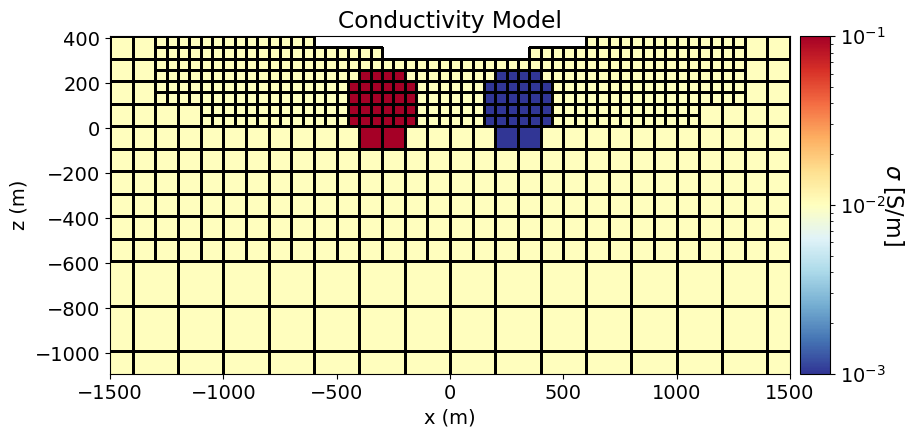

In [14]:
fig = plt.figure(figsize=(10, 4.5))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    plotting_map * conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1500, 1500])
ax1.set_ylim([z_topo.max() - 1500, z_topo.max()])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.RdYlBu_r, norm=norm, orientation="vertical"
)
cbar.set_label("$\sigma$ [S/m]", rotation=270, labelpad=15, size=16)

In [15]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

# Forward Simulation Results

For our test we need to define a seperate simulation class for each Solvers being tested. 

We print the time required to predict data for each solver instance.

In [16]:
solvers = {
    "MKL Pardiso": Solver_pardiso,
    "Pytorch LU": Solver_pytorch,
    "SimPEG (SciPy LU)": Solver_simpeg,     
    "CuPy LU": Solver_cupy,
    
}

for solver_name, solver_instance in solvers.items():
# DC simulation for a conductivity model
    simulation = dc.simulation.Simulation3DNodal(
        mesh, survey=survey, sigmaMap=conductivity_map, solver = solver_instance
    )
    start_time = time.time()
    dpred = simulation.dpred(conductivity_model)
    end_time = time.time()
    #print problem size
    if solver_name == "MKL Pardiso":
        print('For problem AX=b with A matrix of size',simulation.Ainv.A.shape, 'and b of size',survey.nSrc)
    #print times
    print(f"Time to run simulation with {solver_name} solver: {end_time-start_time} seconds")

For problem AX=b with A matrix of size (28564, 28564) and b of size 108
Time to run simulation with MKL Pardiso solver: 2.631314992904663 seconds
Time to run simulation with Pytorch LU solver: 16.436639070510864 seconds
Time to run simulation with SimPEG (SciPy LU) solver: 11.663026332855225 seconds
Time to run simulation with CuPy LU solver: 1068.3546755313873 seconds


# Optional

## Plot Data in Pseudosection

In [20]:
apparent_conductivity = apparent_resistivity_from_voltage(survey, dpred) ** -1
# line IDs
n_lines = len(end_locations_list)
n_data_per_line = int(survey.nD / n_lines)
lineID = np.hstack([(ii + 1) * np.ones(n_data_per_line) for ii in range(n_lines)])

In [21]:
survey_2d_list, index_list = convert_survey_3d_to_2d_lines(
    survey, lineID, data_type="volt", output_indexing=True
)

In [23]:
dobs_2d_list = []
apparent_conductivities_2d = []
for ind in index_list:
    dobs_2d_list.append(dpred[ind])
    apparent_conductivities_2d.append(apparent_conductivity[ind])

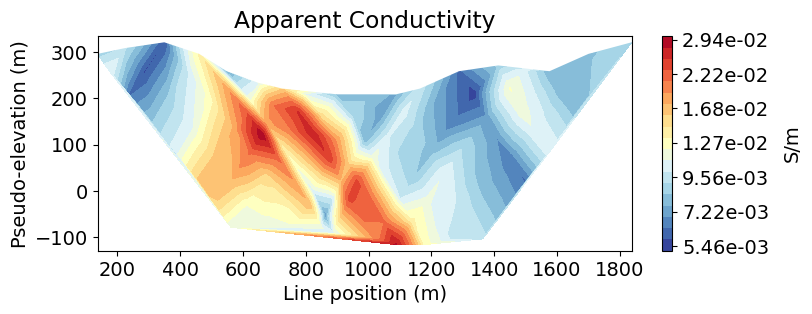

In [24]:
# Line index
line_ind = 0

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey_2d_list[line_ind],
    dobs=apparent_conductivities_2d[line_ind],
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Conductivity")
plt.show()